In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

from IPython.display import display

# https://photutils.readthedocs.io/en/stable/detection.html
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

In [2]:
class sky(object):
    
    def __init__(self, seed=42, arcsec=100, objects=2, factor=1):
        "simulate objects"
        self.rng = np.random.default_rng(seed=seed)
        self.arcsec = arcsec
        obj = self.rng.random(size=(objects, 3))
        obj[:,:2] *= arcsec * factor # compress
        obj[:,:2] += arcsec * (1-factor)/2 # shift
        if True:
            obj[:,2] += 3
            obj[:,2] /= 4
        self.truth = pd.DataFrame(obj, columns=["x", "y", "u"])
    
    def photons(self, sigma_arcsec, exptime=100):
        "fig 1 of https://arxiv.org/pdf/0805.2366.pdf"
        for it,row in self.truth.iterrows():
            yield self.rng.normal(loc=[row.x,row.y], scale=sigma_arcsec, size=(int(row.u*exptime),2))

            
class observer(object):
    
    def __init__(self, patch, pixel_arcsec=0.2):
        self.patch = patch
        self.pixel_arcsec = pixel_arcsec
    
    @property
    def truth(self):
        return self.patch.truth[['x','y']] / self.pixel_arcsec
    
    def image(self, sigma_arcsec, exptime=10000, bg=0):
        "simulate an image"
        pix = 1+int(np.ceil(self.patch.arcsec / self.pixel_arcsec))
        img = np.zeros((pix,pix), dtype=np.float64)
        for it,arcsec in enumerate(self.patch.photons(sigma_arcsec, exptime)):
            t = np.floor(arcsec / self.pixel_arcsec).astype(int)
            for i,j in t: # lazy hack
                img[j,i] += 1
        if bg:
            img += self.patch.rng.poisson(bg * exptime, img.shape)
        return img
    
    @staticmethod
    def daofind(data, fwhm=4, threshold=5, sigma_clip=3):
        "source detection, see at https://photutils.readthedocs.io/en/stable/detection.html"
        mean, median, std = sigma_clipped_stats(data, sigma=sigma_clip) 
        daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold*std)  
        return daofind(data - median), std

In [3]:
# simulate a patch of sky
patch = sky(seed=141, arcsec=7, objects=3, factor=0.5)
obs = observer(patch)

# show the true pixel coordinates
display(obs.truth)

# Gaussian FWHM is not quite the sigma, see https://en.wikipedia.org/wiki/Full_width_at_half_maximum
fwhm_to_sigma = 0.5 / np.sqrt(2*np.log(2))

# create catalogs with random PSFs
cat = dict()
for it, fwhm_arcsec in enumerate(patch.rng.normal(0.65, 0.15, 5)):
    print (f'FWHM in pixels: {fwhm_arcsec/obs.pixel_arcsec}')
    img = obs.image(sigma_arcsec=fwhm_arcsec*fwhm_to_sigma, exptime=100000, bg=0.5)
    src, std = observer.daofind(img, fwhm=fwhm_arcsec/obs.pixel_arcsec, threshold=5, sigma_clip=3)
    if src: src['fwhm'] = fwhm_arcsec * np.ones_like(src['xcentroid'])
    cat[it] = dict(img=img, std=std, dao=src) # save results
    display(src[['id','xcentroid','ycentroid','fwhm']])

,x,y
0,21.635189,26.203857
1,11.920253,18.193956
2,15.473157,13.899509


FWHM in pixels: 2.89917732620968


id,xcentroid,ycentroid,fwhm
int64,float64,float64,float64
1,14.916331849744253,13.418518221460632,0.5798354652419361
2,11.523127387478704,17.686708052441652,0.5798354652419361
3,21.162163674695673,25.74086095000221,0.5798354652419361


FWHM in pixels: 3.688391236822504


id,xcentroid,ycentroid,fwhm
int64,float64,float64,float64
1,14.98636782472369,13.535996841493382,0.7376782473645008
2,11.473760741619364,17.73072916340692,0.7376782473645008
3,21.09962065855529,25.71929361271667,0.7376782473645008


FWHM in pixels: 3.286826894919477


id,xcentroid,ycentroid,fwhm
int64,float64,float64,float64
1,14.935078622132556,13.466319648405463,0.6573653789838955
2,11.447695328743205,17.654411572544536,0.6573653789838955
3,21.265306298024186,25.636344109859305,0.6573653789838955


FWHM in pixels: 4.1744334303813835


id,xcentroid,ycentroid,fwhm
int64,float64,float64,float64
1,14.857470673864695,13.456588910185422,0.8348866860762768
2,11.511385236710636,17.609714369317587,0.8348866860762768
3,21.13741556848896,25.74889847979351,0.8348866860762768


FWHM in pixels: 2.116616675323224


id,xcentroid,ycentroid,fwhm
int64,float64,float64,float64
1,14.972894068181262,13.447061430559351,0.4233233350646448
2,11.465453801493576,17.68665552371086,0.4233233350646448
3,21.11592817516655,25.699074866286704,0.4233233350646448


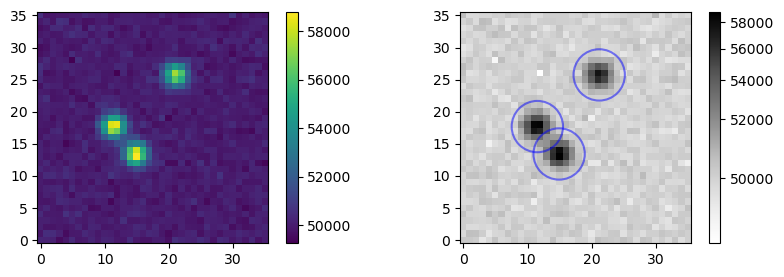

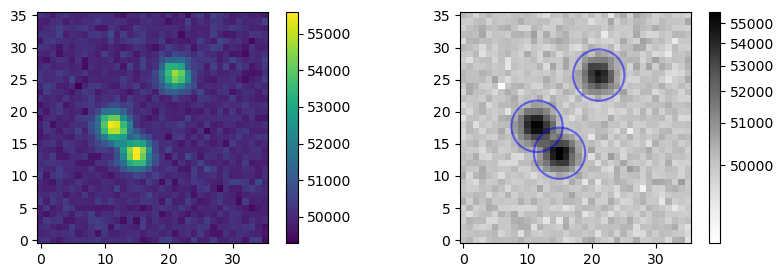

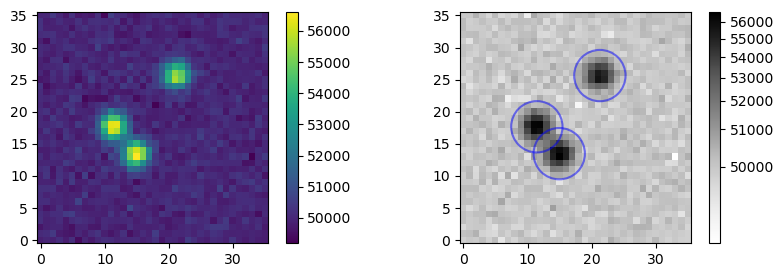

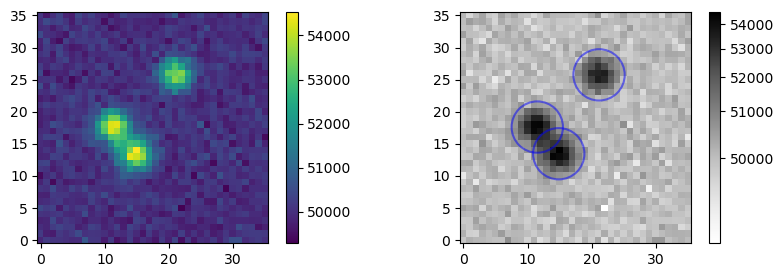

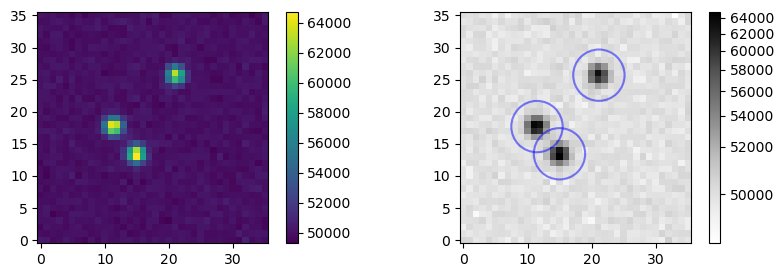

In [4]:
for c in cat.values():
    img, src, std = c['img'], c['dao'], c['std']
    #display(src) #[['id','xcentroid','ycentroid','psf']])
    plt.figure(figsize=(10,3)); plt.subplot(1,2,1)
    plt.imshow(img, interpolation='nearest', aspect='equal', origin='lower'); plt.colorbar();    
    positions = np.transpose((src['xcentroid'], src['ycentroid']))
    plt.subplot(1,2,2)
    plt.imshow(img, cmap='Greys', origin='lower', norm=ImageNormalize(stretch=SqrtStretch()), interpolation='nearest')
    apertures = CircularAperture(positions, r=4.)
    apertures.plot(color='blue', lw=1.5, alpha=0.5); plt.colorbar();

In [5]:
cat[0]['dao']

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,fwhm
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64
1,14.916331849744253,13.418518221460632,0.513741333634223,0.12703483558616283,0.10293486669482654,25,0.0,8777.0,5.999133061854506,-1.9452212369357713,0.5798354652419361
2,11.523127387478704,17.686708052441652,0.49190399811335533,-0.17625771821208555,-0.15618286939525783,25,0.0,8282.0,5.4568000457658705,-1.842345100413737,0.5798354652419361
3,21.162163674695673,25.74086095000221,0.49589183777034174,-0.1702173051936761,-0.020929007754269473,25,0.0,7456.0,5.169049395646851,-1.783526705808257,0.5798354652419361


In [6]:
import sep 

# https://sep.readthedocs.io/en/v1.1.x/tutorial.html

In [7]:
from matplotlib.patches import Ellipse

def plot_sep(data_sub, objects, f=1):
    # plot background-subtracted image
    fig, ax = plt.subplots()
    m, s = np.mean(data_sub), np.std(data_sub)
    im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
                   vmin=m-s, vmax=m+f*s, origin='lower')

    # plot an ellipse for each object
    for i in range(len(objects)):
        e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                    width=6*objects['a'][i],
                    height=6*objects['b'][i],
                    angle=objects['theta'][i] * 180. / np.pi)
        e.set_facecolor('none')
        e.set_edgecolor('red')
        ax.add_artist(e)
    return fig, ax

In [8]:
for c in cat.values():
    img, src, std = c['img'], c['dao'], c['std']
    
    # measure a spatially varying background on the image
    bkg = sep.Background(img)    
    
    #display((k, bkg.globalback, bkg.globalrms))
    if False:
        bkg_image = bkg.back()
        bkg_rms = bkg.rms()
        # show the background
        plt.figure(figsize=(10,4)); plt.subplot(1,2,1)
        plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower'); plt.colorbar(); plt.subplot(1,2,2)
        plt.imshow(bkg_rms, interpolation='nearest', cmap=plt.cm.seismic, origin='lower'); plt.colorbar();

    # source extraction
    sources = sep.extract(img - bkg, 5, err=std)
    #display(sources)
    
    c['sep'] = pd.DataFrame(sources)
    
    # plot_sep(img-bkg, sources, f=10)

In [9]:
display(cat[0]['dao'][['xcentroid','ycentroid']])
display(cat[0]['sep'][['x','y','x2','errx2','erry2','errxy','cxx','cyy','cxy']])

xcentroid,ycentroid
float64,float64
14.916331849744253,13.418518221460632
11.523127387478704,17.686708052441652
21.162163674695673,25.74086095000221


,x,y,x2,errx2,erry2,errxy,cxx,cyy,cxy
0,14.876717,13.482944,1.331519,0.000383,0.000498,-0.000025,0.755253,0.643172,0.104332
1,11.485275,17.700337,1.402808,0.000415,0.000450,-0.000030,0.715225,0.679496,0.080251
2,21.121882,25.790906,1.302761,0.000535,0.000539,-0.000055,0.770689,0.792353,0.098943


In [10]:
display(cat[0]['dao'][['xcentroid','ycentroid']])

cols = [c for c in cat[0]['sep'].columns if c.find('x')>=0 or c.find('y')>=0]
display(cat[0]['sep'][cols])

xcentroid,ycentroid
float64,float64
14.916331849744253,13.418518221460632
11.523127387478704,17.686708052441652
21.162163674695673,25.74086095000221


,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,y2,...,errxy,cxx,cyy,cxy,cflux,flux,xcpeak,ycpeak,xpeak,ypeak
0,25,22,13,17,11,16,14.876717,13.482944,1.331519,1.563554,...,-0.000025,0.755253,0.643172,0.104332,76985.84375,82075.46875,15,13,15,13
1,25,21,9,14,15,20,11.485275,17.700337,1.402808,1.476572,...,-0.000030,0.715225,0.679496,0.080251,78170.03125,83581.46875,11,18,12,18
2,22,19,19,23,24,28,21.121882,25.790906,1.302761,1.267143,...,-0.000055,0.770689,0.792353,0.098943,60982.50000,66705.81250,21,26,21,26


In [11]:
cat[0].keys()

dict_keys(['img', 'std', 'dao', 'sep'])

# Matching

In [12]:
import random
import string
import math
import time
import itertools
from math import log as ln
from math import exp
import pandas as pd
import numpy as np
from gurobipy import *
from scipy import spatial
from scipy import sparse
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import squareform, pdist

plt.rcParams['text.usetex'] = True

In [21]:
tup_dict = {}
candidate_list = []
catalog_list = []
df_rows = []
coord_dict = {}
Sigma_list = []
for catalog_id, c in cat.items():
    c = c['sep']
    for row in c.itertuples(index=True):
        source_num = row.Index
        x = row.x
        y = row.y
        errx2 = row.errx2
        erry2 = row.erry2
        candidate_list.append((source_num, catalog_id))
        catalog_list.append(catalog_id)
        err = (math.sqrt(errx2) + math.sqrt(erry2)) * 0.5
        df_rows.append([source_num, catalog_id,x,y])
        coord_dict[(source_num, catalog_id)] = [x,y]
        Sigma_list.append(err)

kappa_dict = {}
kappa_rad_dict = {}
ln_kappa_rad_dict = {}

detection_total = len(candidate_list) 

df = pd.DataFrame(df_rows, columns=['Catalog_id', 'Source_id', 'Coordinate_1', 'Coordinate_2'])
        
for i in range(len(candidate_list)):
    kappa_dict[(candidate_list[i][0], candidate_list[i][1])] = 1/(Sigma_list[i])**2 #in arcsecond 
    kappa_rad_dict[(candidate_list[i][0], candidate_list[i][1])] = 1/((Sigma_list[i]*np.pi/180/3600)**2) #in radian
    ln_kappa_rad_dict[(candidate_list[i][0], candidate_list[i][1])] = math.log(1/((Sigma_list[i]*np.pi/180/3600)**2))
    
sigma_min = min(Sigma_list)
sigma_max = max(Sigma_list)

In [14]:
def get_distance_2(list_of_indexes, coord_dict):
    '''
    Given 2 pairs of (source_index, catalog_index), return the square distance between them
    df has the columns ('Catalog id', 'Source id', Coord 1, Coord 2)
    '''
    c1 = coord_dict[list_of_indexes[0]]
    c2 = coord_dict[list_of_indexes[1]]
    
    return ((c1[0] - c2[0]) ** 2) + ((c1[1] - c2[1]) ** 2)

def sum_of_distance(list_of_objects, df):
    '''
    Given n pairs of (catalog_index, source_index), return the sum of all pairwise square distance.
    '''
    num_of_objects = len(list_of_objects)
    coord_list = []
    for i in range(num_of_objects):
        coord_list+=[np.array(df[(df['Catalog_id'] == list_of_objects[i][1]) & (df['Source_id'] == list_of_objects[i][0])].iloc[:,-2:])[0]]
    array_matrix = np.array(coord_list)
    pairwise_dist = spatial.distance.pdist(np.array(array_matrix))**2
    sum_of_square_dist = sum(pairwise_dist)
    return sum_of_square_dist

def Bayes_factor(list_of_objects, coord_dict):
    '''
    Compute -ln B_o
    '''
    sum_ln_kappa_rad = 0
    kappa_rad_sum = 0
    kappa_sum = 0
    neg_ln_Bayes = 0
    num_of_objects = len(list_of_objects)
    
    for tup in list_of_objects:
        sum_ln_kappa_rad += ln(kappa_rad_dict[tup])
        kappa_rad_sum += kappa_rad_dict[tup]
        kappa_sum += kappa_dict[tup]
    
    double_sum = 0
    
    for index_1 in range(num_of_objects):
        for index_2 in range(index_1+1,num_of_objects):
            double_sum += kappa_dict[list_of_objects[index_1]]*kappa_dict[list_of_objects[index_2]]*get_distance_2([list_of_objects[index_1],list_of_objects[index_2]],coord_dict)
    
    double_sum *= (1/(4*kappa_sum))
    
    neg_ln_Bayes = double_sum + (1 - num_of_objects)*ln(2) - sum_ln_kappa_rad + ln(kappa_rad_sum)
    return neg_ln_Bayes

def compute_distance_dictionary_2(list_of_indices, coord_dict):
    '''
    Return a dictionary with the form: dict[('Source_id_1', 'Catalog_id_1'), ('Source_id_2', 'Catalog_id_2')] = square distance between them. 
    '''
    distance_dict = {}
    for current_pair_index in range(len(list_of_indices)):
        for next_pair_index in range(current_pair_index + 1, len(list_of_indices)):
            if list_of_indices[next_pair_index][1]!= list_of_indices[current_pair_index][1]: # Only find distances for sources from different catalogs
                distance_dict[(list_of_indices[current_pair_index],list_of_indices[next_pair_index])] = get_distance_2([list_of_indices[current_pair_index],list_of_indices[next_pair_index]], coord_dict)
    return distance_dict


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    
    ind = linear_sum_assignment(w.max() - w)
    ind = np.array(list(zip(*ind)))
    
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

def plot_obj_dict(obj_dict, method, neg_log_bayes, acc, filename = None):
    plt.figure(figsize=(4,4))
    plt.title(f"Clustered via {method} \n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes:.2f}$ \n"
              fr"Accuracy = ${acc * 100:.2f}$ \%")
    for tup_list in obj_dict.values():
        X = [coord_dict[t] for t in tup_list]
        X = np.array(X)
        plt.scatter(X.T[0], X.T[1],s=5.0)
    
    if filename:
        plt.savefig(filename, bbox_inches="tight", pad_inches=0.2, format="svg")
    
    plt.show()

def plot_catalogs(cat_tups, filename = None):
    catalog_groups = defaultdict(list)
    for t in cat_tups:
        catalog_groups[t[1]].append(t)
    plt.figure(figsize=(4,4))
    plt.title("Sources by Catalog")
    for l in catalog_groups.values():
        X = [coord_dict[t] for t in l]
        X = np.array(X)
        plt.scatter(X.T[0], X.T[1],s=5.0)
    
    if filename:
        plt.savefig(filename, format="svg")
    
    plt.show()
    

def plot_objects(cat_tups, filename = None):
    catalog_groups = defaultdict(list)
    for t in cat_tups:
        catalog_groups[t[0]].append(t)
    plt.figure(figsize=(4,4))
    plt.title("Sources by Object\n"
              r"$-\sum_{{o\in O}}\log(B_o)=$"
              f"${neg_log_bayes_from_obj_dict(catalog_groups, coord_dict):.2f}$")
    for l in catalog_groups.values():
        X = [coord_dict[t] for t in l]
        X = np.array(X)
        plt.scatter(X.T[0], X.T[1],s=5.0)
    
    if filename:
        plt.savefig(filename, format="svg")
    
    plt.show()
    
def neg_log_bayes_from_obj_dict(obj_dict, coord_dict):
    """
    Calculate the total negative log bayes factor
    from a dictionary of object lists.
    """
    neg_log_bayes = 0
    for obj_num, tup_list in obj_dict.items():
        neg_log_bayes += Bayes_factor(tup_list, coord_dict)
    return neg_log_bayes

def obj_dict_to_true_pred_labels(obj_dict):
    pred_dict = dict()
    true_dict = dict()
    
    for k,l in obj_dict.items():
        for t in l:
            pred_dict[t] = k
            true_dict[t] = t[0]
    
    n_samples = len(pred_dict)
    y_pred = np.zeros(n_samples, dtype=int)
    y_true = np.zeros(n_samples, dtype=int)
    
    for i, (t,label) in enumerate(pred_dict.items()):
        y_pred[i] = label
        y_true[i] = true_dict[t]
    
    return y_pred, y_true

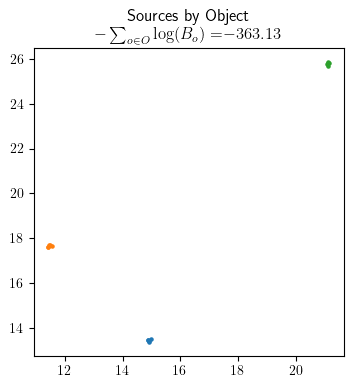

In [23]:
plot_objects(candidate_list)

In [24]:
time1 = time.perf_counter()

N = 0
dims = 2
num_datapoints = len(coord_dict)
use_heuristic = False
num_catalog = len(cat)

model = Model("MIP Quad")

# Range of cluster values
x_coords = df['Coordinate_1']
y_coords = df['Coordinate_2']

# Add cluster (c) decision variables
cluster_vars = model.addVars(detection_total, dims, lb=-float('inf'), ub=float('inf'))

# Add boolean variables
x = model.addVars(candidate_list, list(range(detection_total)), vtype=GRB.BINARY)

# p variables
p = model.addVars(detection_total, lb = 0.0, ub = float('inf'))

# Heuristic start
if use_heuristic:
    for j in range(detection_total):
        for source, catalog in candidate_list:
            if j in starting_heuristic_obj_dict and (source,catalog) in starting_heuristic_obj_dict[j]:
                x[source,catalog,j].VarHintVal = 1.0
            else:
                x[source,catalog,j].VarHintVal = 0.0

# Add M variable
M = np.max(pdist(df[["Coordinate_1", "Coordinate_2"]], 'sqeuclidean')) * max(list(kappa_dict.values())) * 1.1 # max pairwise distance * 2
# M = 10**6

# Add r variables
r_dict = model.addVars(candidate_list, lb=0.0, ub=float('inf'))

# Log term
rounding_index = -2 #round number to nearest 10 if rounding_index = -1. to round to nearest 100, change to -2
error_threshold = 1/100 * min(ln_kappa_rad_dict.values())

var_chi_dict = {}
b_list = [ln(1/(sigma_max*np.pi/180/3600)**2)]
# Compute b_list
while b_list[-1] < ln(num_catalog/(sigma_min*np.pi/180/3600)**2):
    b_list.append(b_list[-1]+error_threshold)
    
num_breakpoints = len(b_list) # = P in the paper

# Variables for chi
for j in range(detection_total):
    for b_i in range(num_breakpoints):
        var_chi_dict[('chi', j, b_i)] = model.addVar(vtype=GRB.BINARY, name=str(('chi', j, b_i)))

# Objective
model.setObjective((0.25 * r_dict.sum()) + p.sum()
                   + quicksum((b_list[0] * var_chi_dict[('chi', j, 0)])
                              + (error_threshold * quicksum(var_chi_dict[('chi', j, b_i)] for b_i in range(1,num_breakpoints)))
                            for j in range(detection_total))
                  , GRB.MINIMIZE)

# Constraints
# Each point assigned to a cluster
for source, catalog in candidate_list:
    model.addConstr(quicksum(x[(source, catalog, j)] for j in range(detection_total)) == 1)
    
# p constraints
for j in range(detection_total):
    for source, catalog in candidate_list:
        model.addConstr(p[0] >= ln(2) * x[source, catalog, j])
    
# Each cluster has at most one source from a catalog
sources_by_catalog = defaultdict(list)
for source, catalog in coord_dict:
    sources_by_catalog[catalog].append(source)
    
for j,c in itertools.product(range(detection_total), range(num_catalog)):
    model.addConstr(quicksum(x[(source,c,j)] for source in sources_by_catalog[c]) <= 1)
    # model.addSOS(GRB.SOS_TYPE1, [x[source,c,j] for source in sources_by_catalog[c]])

# Break symmetry
if N == 0 and not use_heuristic:
    first_s, first_c = candidate_list[0]
    model.addConstr(x[(first_s, first_c, 0)] == 1.0)
    # Assign other members of the first catalog to other clusters
    clust = 1
    for source, catalog in candidate_list:
        if catalog == first_c and source != first_s:
            model.addConstr(x[(source,catalog,clust)] == 1.0)
            clust += 1
            print(source,catalog)

for j in range(detection_total):
    model.addConstr(cluster_vars[j,0] == [min(x_coords), max(x_coords)])
    model.addConstr(cluster_vars[j,1] == [min(y_coords), max(y_coords)])


# Big-M constraints
for (source, catalog), coord in coord_dict.items():
    for j in range(detection_total):
        model.addQConstr(kappa_dict[(source,catalog)] * (((cluster_vars[j,0] - coord[0]) ** 2) + ((cluster_vars[j,1] - coord[1]) ** 2))
                         <= 
                         r_dict[(source, catalog)] + (M * (1 - x[(source, catalog, j)])))

# Definition of variables chi
# Equation B19
for subset_index in range(detection_total):
    chi_constraint_with_b = []
    chi_constraint = []
    x_constraint = []
    for breakpoint_index in range(1, num_breakpoints):
        chi_constraint_with_b.append(var_chi_dict[('chi', subset_index, breakpoint_index)]*(exp(b_list[breakpoint_index])-exp(b_list[breakpoint_index-1]))/10**10) #Divide by 10**10 to scale the coefficient so that the matrix range is not so large across all the constraints
    for source, catalog in candidate_list:
        x_constraint.append(x[(source, catalog, subset_index)]*kappa_rad_dict[(source, catalog)]/10**10) 
        #Divide by 10**10 to scale the coefficient so that the matrix range is not so large across all the constraints
    model.addConstr(exp(b_list[0])* var_chi_dict[('chi', subset_index, 0)] + quicksum(variable for variable in chi_constraint_with_b) >= quicksum(variable for variable in x_constraint))
    
    for breakpoint_index in range(num_breakpoints):
        chi_constraint.append(var_chi_dict[('chi', subset_index, breakpoint_index)])
    for chi_index in range(len(chi_constraint) - 1):
        model.addConstr(chi_constraint[chi_index] >= chi_constraint[chi_index + 1])

print("Set Up Time:", time.perf_counter() - time1)

1 0
2 0
Set Up Time: 0.018322621999686817


In [25]:
model.setParam('NodefileStart', 5.0)
# model.setParam('Heuristics', 0.001)
model.setParam("PreQLinearize", 1)
model.setParam("MIQCPMethod", 1)
# model.setParam('Aggregate', 2)
model.setParam('Presolve', 2)
# model.setParam('ScaleFlag', 1)
# model.setParam('PreDual', 1)
# model.setParam('NormAdjust', 1)
# model.setParam('BranchDir', -1)
# model.setParam('MIPFocus', 2)

model.optimize()

Set parameter NodefileStart to value 5
Set parameter PreQLinearize to value 1
Set parameter MIQCPMethod to value 1
Set parameter Presolve to value 2
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 528 rows, 495 columns and 1698 nonzeros
Model fingerprint: 0x72762965
Model has 225 quadratic constraints
Variable types: 90 continuous, 405 integer (405 binary)
Coefficient statistics:
  Matrix range     [7e-01, 4e+13]
  QMatrix range    [9e+02, 4e+03]
  QLMatrix range   [1e+00, 9e+05]
  Objective range  [2e-01, 3e+01]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 3e+01]
  QRHS range       [3e+04, 3e+06]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 135 rows and 159 columns
Presolve time: 0.01s
Presolved: 393 rows, 336 columns, 1884 nonzeros
Presolved model has 15 quadratic constraint(s)
Vari

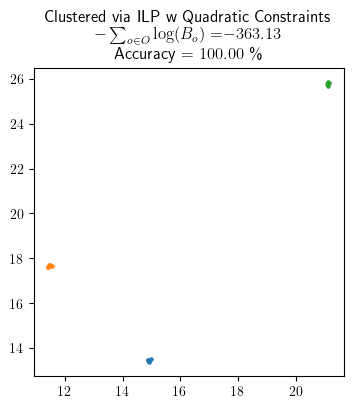

In [26]:
ilpq_obj_dict = defaultdict(list)

for (source, catalog, j), var in x.items():
    if var.X > 0.5:
        ilpq_obj_dict[j].append((source, catalog))

ilpq_y_pred, ilpq_y_true = obj_dict_to_true_pred_labels(ilpq_obj_dict)
ilpq_acc = acc(ilpq_y_pred, ilpq_y_true)
plot_obj_dict(ilpq_obj_dict, "ILP w Quadratic Constraints", neg_log_bayes_from_obj_dict(ilpq_obj_dict, coord_dict), ilpq_acc)